# Starter Notebook
This notebook contains the basic code to train a GeodesyNet on accelerations synthetically generated from a ground truth  mascon model.
At the end of the training a quick look at the resulting neural density field is also given.

On CPU the training will still work but be slow, in that case use less points for the numercial quadrature and smaller batches. If you have access to a GPU everything will go much faster. With an Nvidia RTX2080Ti GPU a full training will take approximately one hour.

In [1]:
# Import our module containing helper functions
import gravann

# Core imports
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

Available devices  10
__pyTorch VERSION: 2.4.1
__CUDNN VERSION: 90100
__Number CUDA Devices: 10
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


/home/pietrofanti/miniforge3/envs/geodesynet/lib/python3.8/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789259345/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


# Loading and visualizing the ground truth asteroid (a point cloud)

In [3]:
# one of "eros", "bennu", "itokawa", "churyumov-gerasimenko", "planetesimal", "torus", "bennu_nu", "itokawa_nu", "planetesimal_nu"
name_of_gt = "bennu"

In [4]:
# We load the ground truth (a mascon model of some body)
with open("mascons/"+name_of_gt+".pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses = torch.tensor(mascon_masses)

# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of mascons: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

# Each mascon has a closest neighbour. The least close one is here computed (non dimensional units).
# Its a quantity that is of interest when checking mascon models coming from gravitationally stable aggregates.
print("Maximal minimal distance:",gravann.max_min_distance(mascon_points))

Name:  Bennu
Number of mascons:  37799
Total mass:  tensor(1.0000, dtype=torch.float64)
Maximal minimal distance: 0.13160134851932526


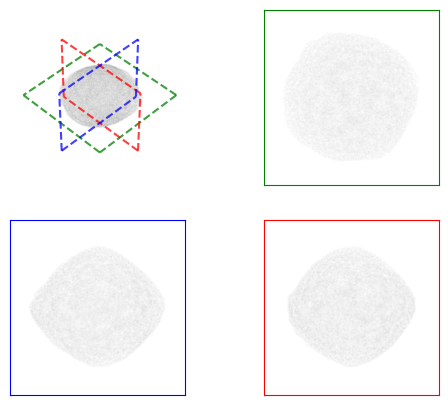

In [5]:
# Here we visualize the loaded ground truth
gravann.plot_mascon(mascon_points, mascon_masses,alpha=0.005)

# Representing the asteroid mass distribution via a neural network


## 1 - Defining the network architecture
We here use functions from our module as to not clutter the notebook, but the code is rather straight forward: a FFNN with some options.

In [7]:
# Encoding: direct encoding (i.e. feeding the network directly with the Cartesian coordinates in the unit hypercube)
# was found to work well in most cases. But more options are implemented in the module.
encoding = gravann.direct_encoding()

# The model is here a SIREN_Q network (FFNN with quadratic layers and sin non linearities and a final absolute value to predict the density)
# A 7x65 (7 hidden layers with 65 neurons each) quadraitc model has more or less the same number of parameters of a 9x100 linear model,
# because a quadratic layers has 3 times the number of weights and biases of a linear one with the same size.
model = gravann.init_network(encoding, n_neurons=65, model_type="siren_q", activation = gravann.AbsLayer(), hidden_layers=7)  

# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []
# .. and we init a loss trend indicators
weighted_average = deque([], maxlen=20)

In [8]:
t = 0
for p in model.parameters():
    t += p.numel()
print(f"Number of parameters of the model: {t}")

Number of parameters of the model: 91068


In [9]:
## ---------------------------------------------------------------------------------------
## IF YOU WANT TO LOAD AN ALREADY TRAINED NETWORK UNCOMMENT HERE.
## 300000 points used for the quadrature, 1000 for batches and trained for 20000 epochs
## If a model is preloaded skip to the later interpretation of results cells
## ---------------------------------------------------------------------------------------

# model.load_state_dict(torch.load("models/"+name_of_gt+".mdl"))

# Once a model is loaded the learned constant c (named kappa in the paper) is unknown 
# and must be relearned (ideally it should also be saved at the end of the training as it is a learned parameter)
c = gravann.compute_c_for_model(model, encoding, mascon_points, mascon_masses, use_acc = True)

/home/pietrofanti/miniforge3/envs/geodesynet/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789259345/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## 2 - Visualizing the initial neural density field
The network output is a mass density in the unit cube. Essentially a three dimensional function which we here plot via rejection sampling (for now this method is good enough)

Sampling points...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling points...: 10891it [00:01, 8148.24it/s]                          


Text(0.5, 1.0, 'Believe it or not I am an asteroid!')

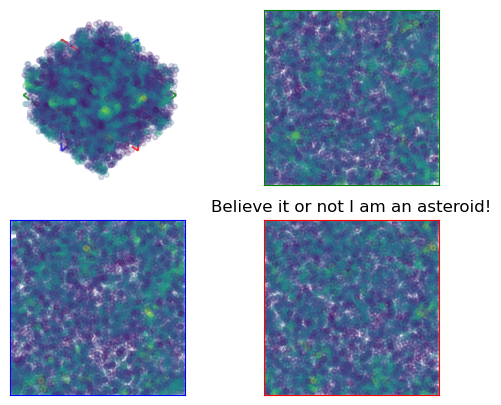

In [10]:
# The rejection plot will visualize the neural density field as a probability distribution function. 
# Colors represent the density magnitude (white being zero). 
# At the beginning, the whole hypercube is filled with some non vanishing density.
gravann.plot_model_rejection(model, encoding, views_2d=True, N=10000, progressbar=True, c=c)
plt.title("Believe it or not I am an asteroid!")

# Training of a geodesyNet

In [11]:
# EXPERIMENTAL SETUP ------------------------------------------------------------------------------------
# Number of points to be used to evaluate numerically the triple integral
# defining the acceleration. 
# Use <=30000 to for a quick training ... 300000 was used to produce most of the paper results
n_quadrature = 30000

# Dimension of the batch size, i.e. number of points
# where the ground truth is compared to the predicted acceleration
# at each training epoch.
# Use 100 for a quick training. 1000  was used to produce most of the paper results
batch_size = 100

# Loss. The normalized L1 loss (kMAE in the paper) was
# found to be one of the best performing choices.
# More are implemented in the module
loss_fn = gravann.normalized_L1_loss

# The numerical Integration method. 
# Trapezoidal integration is here set over a dataset containing acceleration values,
# (it is possible to also train on values of the gravity potential, results are similar)
mc_method = gravann.ACC_trap

# The sampling method to decide what points to consider in each batch.
# In this case we sample points unifromly in a sphere and reject those that are inside the asteroid
targets_point_sampler = gravann.get_target_point_sampler(batch_size, 
                                                         limit_shape_to_asteroid="3dmeshes/"+name_of_gt+"_lp.pk", 
                                                         method="spherical", 
                                                         bounds=[0,1])
# Here we set the optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(
    [
        {'params': [p for n, p in model.named_parameters() if not gravann.is_quadratic_param(n)]},
        {'params': [p for n, p in model.named_parameters() if gravann.is_quadratic_param(n)], 'lr': learning_rate/10},
    ],
    lr=learning_rate
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.8, patience = 200, min_lr = 1e-6,verbose=True)

# And init the best results
best_loss = np.inf
best_model_state_dict = model.state_dict()

/home/pietrofanti/miniforge3/envs/geodesynet/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


**Note: the cell below is explicitly typed for convenience, as this is a tutorial-ish after all, but the module gravann contains a function (train_on_batch) that does the same**

In [12]:
# TRAINING LOOP (normal training, no use of any prior shape information)------------------------
# This cell can be stopped and started again without loosing memory of the training nor its logs
torch.cuda.empty_cache()
# The main training loop
for i in range(20000):
    # Each ten epochs we resample the target points
    if (i % 10 == 0):
        target_points = targets_point_sampler()
        # We compute the labels whenever the target points are changed
        labels = gravann.ACC_L(target_points, mascon_points, mascon_masses)
    
    # We compute the values predicted by the neural density field
    predicted = mc_method(target_points, model, encoding, N=n_quadrature, noise=0.)
    
    # We learn the scaling constant (k in the paper)
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    
    # We compute the loss (note that the contrastive loss needs a different shape for the labels)
    if loss_fn == gravann.contrastive_loss:
       loss = loss_fn(predicted, labels)
    else:
       loss = loss_fn(predicted.view(-1), labels.view(-1))
    
    # We store the model if it has the lowest fitness 
    # (this is to avoid losing good results during a run that goes wild)
    if loss < best_loss:
        best_model_state_dict = model.state_dict()
        best_loss = loss
        print('New Best: ', loss.item())
        # Uncomment to save the model during training (careful it overwrites the model folder)
        #torch.save(model.state_dict(), "models/"+name_of_gt+".mdl")
    
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    n_inferences.append((n_quadrature*batch_size) // 1000000) #counted in millions
    
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
        
    # Zeroes the gradient (necessary because of things)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

/home/pietrofanti/geodesyNets/gravann/_hulls.py:167: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789259345/work/aten/src/ATen/native/Cross.cpp:62.)
  h = torch.cross(ray_d.expand(V, 3), edge2)


New Best:  0.3216535151004791
It=0	 loss=3.217e-01	  weighted_average=3.217e-01	  c=1.728e+01
New Best:  0.22709707915782928
New Best:  0.21776022017002106
New Best:  0.20902873575687408
New Best:  0.20190536975860596
New Best:  0.1966518759727478
New Best:  0.19026745855808258
New Best:  0.18500250577926636
New Best:  0.18029160797595978
New Best:  0.17481695115566254
New Best:  0.16591866314411163
New Best:  0.15547634661197662
New Best:  0.14772561192512512
It=25	 loss=1.477e-01	  weighted_average=1.944e-01	  c=4.712e+00
New Best:  0.14074571430683136
New Best:  0.13445626199245453
New Best:  0.12567023932933807
New Best:  0.1161537691950798
New Best:  0.1154542788863182
New Best:  0.10448537021875381
New Best:  0.0912085697054863
New Best:  0.08326444029808044
New Best:  0.07596669346094131
New Best:  0.07049399614334106
New Best:  0.06562202423810959
New Best:  0.06032451614737511
New Best:  0.05627075210213661
New Best:  0.051497045904397964
New Best:  0.05088764429092407
It=50	 

In [13]:
# Here we restore the learned parameters of the best model of the run
for layer in model.state_dict():
    model.state_dict()[layer] = best_model_state_dict[layer]

# 3 - Interpretation of the neural density field learned

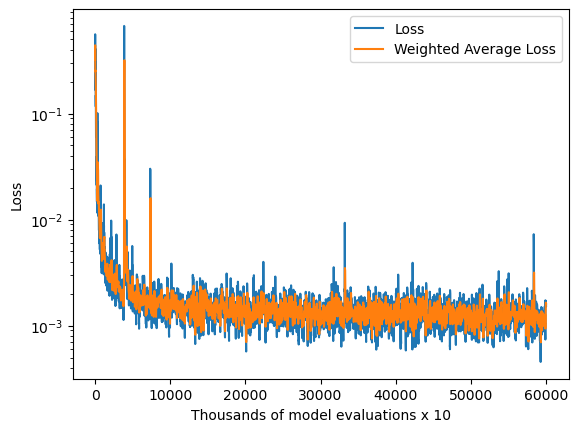

In [14]:
# First lets have a look at the training loss history
plt.figure()
abscissa = np.cumsum(n_inferences)
plt.semilogy(abscissa,  loss_log)
plt.semilogy(abscissa,  weighted_average_log)
plt.xlabel("Thousands of model evaluations x 10")
plt.ylabel("Loss")
plt.legend(["Loss","Weighted Average Loss"])

Sampling points...: 1723it [00:00, 4576.18it/s]                          


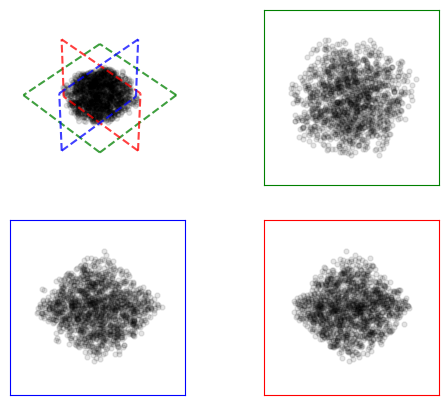

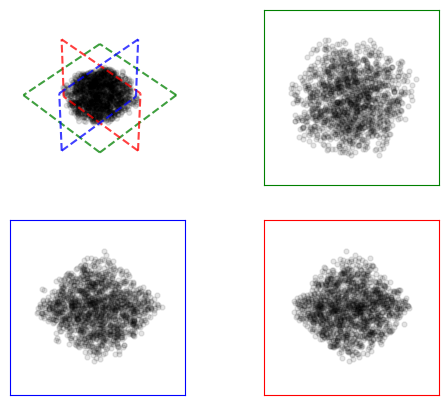

In [15]:
# Lets have a look at the neural density field.
# First with a rejection plot
gravann.plot_model_rejection(model, encoding, views_2d=True, bw=True, N=1500, alpha=0.1, s=50, c=c, crop_p=0.1, progressbar=True)

Sampling points...: 5258it [00:00, 5395.56it/s]                          


<Axes3D: title={'center': '3D View'}, xlabel='X', ylabel='Y', zlabel='Z'>

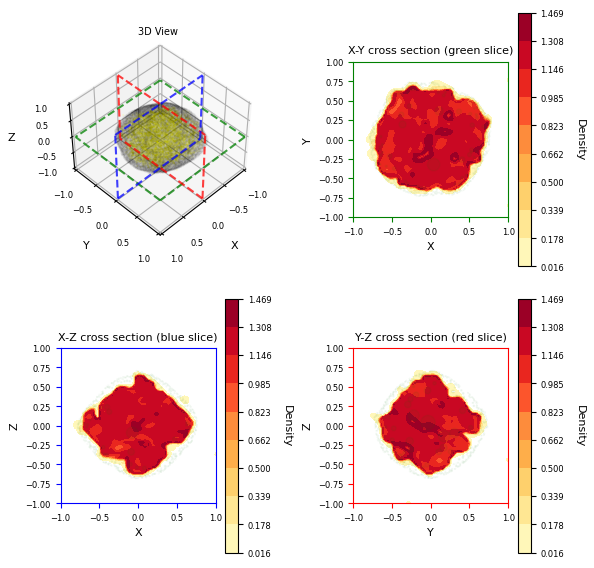

In [16]:
# Then overlaying a heatmap to the mascons 
gravann.plot_model_vs_mascon_contours(model, encoding, mascon_points, mascon_masses,c=c, progressbar = True, N=5000, heatmap=True)

In [18]:
# Computes the Validation table with rel and abs errors on the predicted acceleration (w.r.t. ground truth) 
# at low, med, high altitudes (see paper). is requires sampling quite a lot, so it takes time 
# IMPORTANT: the N_integration should be equal to n_quadrature used for training. Else results degrade.
results_geodesyNet = gravann.validation(model, encoding, mascon_points, mascon_masses, 
                use_acc=True, 
                asteroid_pk_path="3dmeshes/"+name_of_gt+".pk", 
                N=10000, 
                N_integration=30000,  # This needs to be the same as the number used during training, else precision will be lost
                batch_size=100, 
                progressbar=True,
                )

Computing validation...:  34%|███▍      | 25400/74244 [00:45<00:54, 902.27it/s]

Discarding 2610 of 14744 points in altitude sampler which did not meet requested altitude.


Discarding 7795 of 14744 points in altitude sampler which did not meet requested altitude.


Discarding 12502 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...: 74400it [01:39, 744.08it/s]


In [19]:
results_geodesyNet

,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.006800,0.010552,0.036897,0.018459
1,High Altitude,0.000618,0.001203,0.002788,0.001739
2,Altitude_0,0.002588,0.004338,0.009049,0.005039
3,Altitude_1,0.000786,0.001501,0.003154,0.002009
4,Altitude_2,0.000149,0.000406,0.000861,0.000770


In [20]:
# Select the units according to the model used (lazyness... a dict would do better)
factor_planetesimal = 9.982e12 * 6.67430e-11 / 3126.6064453124995**2
factor_itokawa = 3.51e10 * 6.67430e-11 / 350.438691675663**2
factor_eros = 6.687e15 * 6.67430e-11 / 20413.864850997925**2
factor_bennu = (7.329e10   * 6.67430e-11  / 352.1486930549145**2)
factor_67p = 9.982e12 * 6.67430e-11 / 3126.6064453124995**2
factor = factor_eros

In [21]:
absolute = results_geodesyNet["Normalized L1 Loss"] * factor
relative = results_geodesyNet["Normalized Relative Component Loss"] 

In [22]:
# Prints the line for the table 1 in the paper
print(f"{absolute[2]:.2e} & {absolute[3]:.2e} & {absolute[4]:.2e} & {relative[2]*100:.2f} & {relative[3]*100:.2f} & {relative[4]*100:.3f}")

2.77e-06 & 8.41e-07 & 1.59e-07 & 0.43 & 0.15 & 0.041


#### Saving the model

In [ ]:
name_of_model = "quadratic_7_65"

In [19]:
# Uncomment to save the model
torch.save(model.state_dict(), "models/"+name_of_gt+"__"+name_of_model+".mdl")

In [21]:
# save loss logs
import pickle
log_dict = {"loss": loss_log, "weighted_average_loss": weighted_average_log}
with open("logs/"+name_of_gt+"__"+name_of_model+".pkl", 'wb') as f:
    pickle.dump(log_dict, f)